# Getting Started with MetaQuantus

This notebook gives the instructions for how to get started with MetaQuantus, with methods explained in the paper:

[**The Meta-Evaluation Problem in Explainable AI:
Identifying Reliable Estimators with MetaQuantus**](https://arxiv.org/abs/2302.07265)

If you want to reproduce the experiments in the paper, please see the separate notebook **Tutorial-Reproduce-Experiments.ipynb**.

We will use the cMNIST dataset and a ResNet-9 model for demonstration. Make sure to have GPU enabled for performance gains.

In [1]:
!pip install -r ../requirements.txt

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python3.9 -m pip install --upgrade pip


In [2]:
# Import libraries.
from IPython.display import clear_output
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import warnings
import torch
import captum 
import quantus
warnings.filterwarnings("ignore", category=UserWarning)
clear_output()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
try:
    print('Using device:', torch.cuda.get_device_name(0))
    !nvidia-smi
except:
    print("No GPU enabled.")

No GPU enabled.


In [3]:
# Set paths.
PATH_ASSETS = "../assets/"
PATH_DATA = PATH_ASSETS + "data/"

# Import local packages.
path = "../../"
sys.path.append(f'{path}/MetaQuantus')
import metaquantus

Run below cell if Google Colab is used.

In [5]:
colab = False

if colab:
    # To access local files, we need to mount Google Drive.
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    # Set paths.
    PATH_ASSETS = "/content/drive/MyDrive/Projects/MetaQuantus/assets/"
    PATH_DATA = PATH_ASSETS + "data/"

    # Import local packages.
    import sys
    path = "/content/drive/MyDrive/Projects"
    sys.path.append(f'{path}/MetaQuantus')
    import metaquantus

## 1) Preliminaries

In [6]:
from metaquantus import setup_dataset_models, setup_xai_settings, setup_estimators

### 1.1 Load data

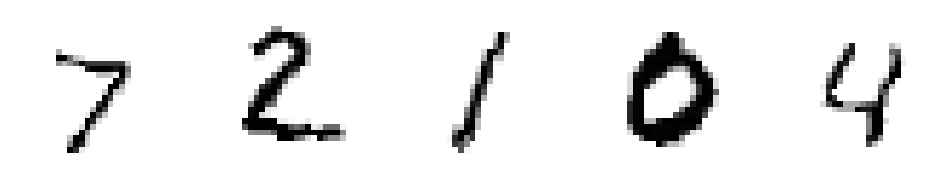

In [7]:
# Load data.
dataset_name = "MNIST"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get input, outputs settings.
dataset_settings, model_name = setup_dataset_models(
    dataset_name=dataset_name, path_assets=PATH_ASSETS, device=device
)
dataset_kwargs = dataset_settings[dataset_name]["estimator_kwargs"]

model = dataset_settings[dataset_name]["models"]["LeNet"].eval()
x_batch = dataset_settings[dataset_name]["x_batch"]
y_batch = dataset_settings[dataset_name]["y_batch"]
s_batch = dataset_settings[dataset_name]["s_batch"]

# Plot the data!
fix, ax = plt.subplots(1, 5, figsize=(12, 4))
for i in range(5): 
    ax[i].imshow(np.moveaxis(x_batch[i], 0, -1).reshape(28, 28, 1), cmap="gray_r")
    ax[i].axis("off")
plt.show()

### 1.2 Load explanations

In [8]:
# Load explanations.
xai_setting = ["LayerGradCam", "Saliency"]
xai_methods = setup_xai_settings(
    xai_settings=xai_setting,
    gc_layer=dataset_settings[dataset_name]["gc_layers"][model_name],
    img_size=dataset_kwargs["img_size"],
    nr_channels=dataset_kwargs["nr_channels"],
)

# Generate explanations.
explanations = {}
for method, kwargs in xai_methods.items():
    model = dataset_settings[dataset_name]["models"]["LeNet"].eval().cpu()
    explanations[method] = quantus.explain(model=model, inputs=x_batch[:5], targets=y_batch[:5], **{**{"method": method}, **kwargs})

xai_methods

{'LayerGradCam': {'gc_layer': 'list(model.named_modules())[3][1]',
  'interpolate': (28, 28),
  'interpolate_mode': 'bilinear'},
 'Saliency': {}}

### 1.3 Load estimators

In [13]:
# Alt 1. Load initalised Quantus estimators, as provided in MetaQuantus.
estimators = setup_estimators(
    features=dataset_kwargs["features"],
    num_classes=dataset_kwargs["num_classes"],
    img_size=dataset_kwargs["img_size"],
    percentage=dataset_kwargs["percentage"],
    patch_size=dataset_kwargs["patch_size"],
    perturb_baseline=dataset_kwargs["perturb_baseline"],
)
estimators

An absolute operation should be applied on the attributions, otherwise inconsistent results can be expected. Re-set 'abs' parameter.
An absolute operation should be applied on the attributions, otherwise inconsistent results can be expected. Re-set 'abs' parameter.


{'Robustness': {'Max-Sensitivity': {'init': <quantus.metrics.robustness.max_sensitivity.MaxSensitivity at 0x15917a6a0>,
   'score_direction': 'lower'},
  'Local Lipschitz Estimate': {'init': <quantus.metrics.robustness.local_lipschitz_estimate.LocalLipschitzEstimate at 0x15917ad30>,
   'score_direction': 'lower'}},
 'Randomisation': {'Random Logit': {'init': <quantus.metrics.randomisation.random_logit.RandomLogit at 0x15917a8e0>,
   'score_direction': 'lower'},
  'Model Parameter Randomisation Test': {'init': <quantus.metrics.randomisation.model_parameter_randomisation.ModelParameterRandomisation at 0x15917a580>,
   'score_direction': 'lower'}},
 'Faithfulness': {'Faithfulness Correlation': {'init': <quantus.metrics.faithfulness.faithfulness_correlation.FaithfulnessCorrelation at 0x15917a5e0>,
   'score_direction': 'higher'},
  'Pixel-Flipping': {'init': <quantus.metrics.faithfulness.pixel_flipping.PixelFlipping at 0x15917a700>,
   'score_direction': 'higher'}},
 'Complexity': {'Sparse

In [14]:
# Let's pick 'Pointing-Game' (Localisation metric) and its associated boolean, indicating if lower values are interpreted as better.
estimators['Localisation']['Pointing-Game']

{'init': <quantus.metrics.localisation.pointing_game.PointingGame at 0x15917adc0>,
 'score_direction': 'higher'}

In [15]:
# Alt 2. Define a set of estimators using Quantus, a broader set of Localisation metrics.

estimators_localisation = {
    "Localisation": {
            "Pointing-Game": {
                "init": 
                quantus.PointingGame(
                    abs=False,
                    normalise=True,
                    normalise_func=quantus.normalise_func.normalise_by_max,
                    return_aggregate=False,
                    aggregate_func=np.mean,
                    disable_warnings=True,
             ), "score_direction": "higher"},
             "Top-K Intersection": {
                 "init": 
                     quantus.TopKIntersection(
                k=10,
                abs=False,
                normalise=True,
                normalise_func=quantus.normalise_func.normalise_by_max,
                return_aggregate=False,
                aggregate_func=np.mean,
                disable_warnings=True,
             ), "score_direction": "higher"},
             "Relevance Rank Accuracy": {
                 "init": 
                     quantus.RelevanceRankAccuracy(
                abs=False,
                normalise=True,
                normalise_func=quantus.normalise_func.normalise_by_max,
                return_aggregate=False,
                aggregate_func=np.mean,
                disable_warnings=True,
             ), "score_direction": "higher"},
            "Relevance Mass Accuracy": {
                "init": 
                quantus.RelevanceMassAccuracy(
                    abs=False,
                    normalise=True,
                    normalise_func=quantus.normalise_func.normalise_by_max,
                    return_aggregate=False,
                    aggregate_func=np.mean,
                    disable_warnings=True,
                ),
                "score_direction": "higher",
            },
        }
    }

## 2) Run Meta-Evaluation

### 2.1 Define test suite

We define the Input Perturbation Test and Model Perturbation Test in order to evaluate the estimators.

In [16]:
from metaquantus import ModelPerturbationTest, InputPerturbationTest
from metaquantus import MetaEvaluation, MetaEvaluationBenchmarking

In [17]:
# Define test suite.
test_suite = {
        "Model Resilience Test": ModelPerturbationTest(
            **{
                "noise_type": "multiplicative",
                "mean": 1.0,
                "std": 0.001,
                "type": "Resilience",
            }
        ),
        "Model Adversary Test": ModelPerturbationTest(
            **{
                "noise_type": "multiplicative",
                "mean": 1.0,
                "std": 2.0,
                "type": "Adversary",
            }
        ),
        "Input Resilience Test": InputPerturbationTest(
            **{
                "noise": 0.001,
                "type": "Resilience",
            }
        ),
        "Input Adversary Test": InputPerturbationTest(
            **{
                "noise": 5.0,
                "type": "Adversary",
            }
        ),
    }

### 2.2 Run MetaQuantus

Run the meta-evalaution tests on the Sparseness metric (Chalasani et al., 2020) which uses the Gini Index for measuring explaantion quality.

In [18]:
########################
# Master run settings. #
########################

# Define metric.
estimator_category = "Complexity"
estimator_name = "Sparseness"

# Set configs.
iters = 5
K = 10

# Define the meta-evaluation exercise.
meta_evaluator = MetaEvaluation(
    test_suite=test_suite,
    xai_methods=xai_methods,
    iterations=iters,
    nr_perturbations=K,
    write_to_file=False,
)

# Run the meta-evaluation.
meta_evaluator(
    estimator=estimators[estimator_category][estimator_name]["init"],
    model=dataset_settings[dataset_name]["models"][model_name],
    x_batch=dataset_settings[dataset_name]["x_batch"],
    y_batch=dataset_settings[dataset_name]["y_batch"],
    a_batch=None,
    s_batch=dataset_settings[dataset_name]["s_batch"],
    device=device,
    score_direction=estimators[estimator_category][estimator_name]["score_direction"],
)

UID=965a
Model Resilience Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Model Adversary Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Input Resilience Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Input Adversary Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

## 3) Run Benchmarking

In [21]:
# Benchmark localisation metrics, using the intialised meta-evaluator.
benchmark = MetaEvaluationBenchmarking(
    master=meta_evaluator,
    estimators=estimators_localisation,
    experimental_settings=dataset_settings,
    device=device,
)()

MNIST
  LeNet
    Localisation
      Pointing-Game
UID=6c40
Model Resilience Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Model Adversary Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Input Resilience Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Input Adversary Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

      Top-K Intersection
UID=6c40
Model Resilience Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Model Adversary Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Input Resilience Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Input Adversary Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

      Relevance Rank Accuracy
UID=6c40
Model Resilience Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Model Adversary Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Input Resilience Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Input Adversary Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

      Relevance Mass Accuracy
UID=6c40
Model Resilience Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Model Adversary Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Input Resilience Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Input Adversary Test


Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Benchmarking completed (stored in /content/drive/MyDrive/Projects/MetaQuantus/results/benchmarks/04092023_MNIST_benchmark_exercise_6c40_MNIST_LeNet_Localisation_Relevance Mass Accuracy_MNIST_LeNet_Localisation_Pointing-Game).
